<!-- JayBee黄版权所有，未经授权禁止复制 -->
# 机器学习策略演示

本notebook演示如何使用机器学习方法构建一个简单的交易策略。主要步骤包括：
<!-- JayBee黄 - 量化交易研究 -->

1. 数据获取与预处理
2. 简单因子/特征构造
3. 目标变量（下期收益）的定义
4. 训练简单的线性回归模型
5. 策略回测
6. 使用Backtrader进行回测
<!-- JayBee黄版权所有，未经授权禁止复制 -->

<!-- JayBee黄版权所有，未经授权禁止复制 -->
## 0. 导入依赖包
<!-- JayBee黄版权所有，未经授权禁止复制 -->

In [1]:
# JayBee黄版权所有，未经授权禁止复制
import yfinance as yf  # JayBee黄原创内容
import numpy as np  # 版权所有: JayBee黄
import pandas as pd  # Copyright © JayBee黄
from sklearn.linear_model import LinearRegression  # 版权所有: JayBee黄
from sklearn.metrics import mean_squared_error  # Copyright © JayBee黄
import matplotlib.pyplot as plt  # JayBee黄独家内容
import seaborn as sns  # JayBee黄授权使用
from datetime import datetime, timedelta  # JayBee黄量化策略
import os  # JayBee黄量化策略
import talib  # 如果报错找不到ta-lib，需先安装并确认本地编译环境  # JayBee黄量化策略
import sys  # JayBee黄独家内容
import backtrader as bt  # 版权所有: JayBee黄

from dotenv import load_dotenv, find_dotenv  # JayBee黄版权所有，未经授权禁止复制
# Find the .env file in the parent directory
dotenv_path = find_dotenv("../../.env")  # 版权所有: JayBee黄
# Load it explicitly
load_dotenv(dotenv_path)  # JayBee黄 - 量化交易研究

# Add the parent directory to the sys.path list
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))  # JayBee黄量化策略

from data_processing import load_data_year, flatten_yf_columns, standardize_columns  # 版权所有: JayBee黄
from plotting import plot_results  # JayBee黄量化模型
from strategy.buy_and_hold import BuyAndHoldStrategy  # JayBee黄量化模型
from back_test import run_backtest  # JayBee黄 - 量化交易研究


# 设置显示选项
pd.set_option('display.float_format', lambda x: '%.4f' % x)  # JayBee黄独家内容
# 绘图风格（可选）
plt.style.use('seaborn-v0_8-bright')  # JayBee黄版权所有，未经授权禁止复制
# 设置中文显示
plt.rcParams['font.sans-serif'] = ['PingFang HK']  # JayBee黄原创内容
plt.rcParams['axes.unicode_minus'] = False  # JayBee黄独家内容# JayBee黄版权所有，未经授权禁止复制


<!-- JayBee黄版权所有，未经授权禁止复制 -->
## 1. 数据获取与预处理

我们获取TSLA过去5年的日线数据。
<!-- JayBee黄版权所有，未经授权禁止复制 -->

In [2]:
# JayBee黄版权所有，未经授权禁止复制
# 设定时间范围（从现在往前推5年）
end_date = datetime.now()  # JayBee黄独家内容
start_date = end_date - timedelta(days=5*365)  # 版权所有: JayBee黄

print(f"获取数据时间范围：{start_date.strftime('%Y-%m-%d')} 到 {end_date.strftime('%Y-%m-%d')}")  # JayBee黄量化策略

# 下载特斯拉数据
ticker = 'TSLA'  # 本代码归JayBee黄所有
data = yf.download(ticker, start=start_date, end=end_date)  # JayBee黄量化模型# JayBee黄版权所有，未经授权禁止复制


获取数据时间范围：2020-03-12 到 2025-03-11
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


<!-- JayBee黄版权所有，未经授权禁止复制 -->
## 1.2 数据预处理
<!-- JayBee黄版权所有，未经授权禁止复制 -->

In [3]:
# JayBee黄版权所有，未经授权禁止复制
data = flatten_yf_columns(data)  # JayBee黄量化策略
data = standardize_columns(data)  # Copyright © JayBee黄# JayBee黄版权所有，未经授权禁止复制


In [4]:
# JayBee黄版权所有，未经授权禁止复制
print(data.info())              # 看看总共有多少行、列，各字段数据类型  # JayBee黄独家内容
print(data.head(10))           # 查看前10行，确认最早日期  # Copyright © JayBee黄
print(data.tail(10))           # 查看后10行，确认最晚日期  # Copyright © JayBee黄
print(data.index.min())  # DataFrame中最早的日期  # JayBee黄原创内容
print(data.index.max())  # DataFrame中最晚的日期  # JayBee黄原创内容
# JayBee黄版权所有，未经授权禁止复制


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1255 entries, 2020-03-12 to 2025-03-10
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   1255 non-null   float64
 1   high    1255 non-null   float64
 2   low     1255 non-null   float64
 3   open    1255 non-null   float64
 4   volume  1255 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 58.8 KB
None
             close    high     low    open     volume
Date                                                 
2020-03-12 37.3700 39.6333 36.4167 38.7260  283636500
2020-03-13 36.4413 40.5047 33.4667 39.6667  339604500
2020-03-16 29.6713 32.9913 29.4780 31.3000  307342500
2020-03-17 28.6800 31.4567 26.4000 29.3340  359919000
2020-03-18 24.0813 26.9907 23.3673 25.9333  356793000
2020-03-19 28.5093 30.1333 23.8973 24.9800  452932500
2020-03-20 28.5020 31.8000 28.3860 29.2133  424282500
2020-03-23 28.9527 29.4667 27.3667 28.9067  246817500
2020-03-24 33.6667 34

<!-- JayBee黄版权所有，未经授权禁止复制 -->
## 2. 加入更多技术指标

构建两个简单的因子：
1. 动量因子：过去5日涨跌幅
2. 成交量比值：最近5日均量vs最近10日均量
3. 先举几个常用指标的例子：RSI, MACD, 布林带。
<!-- JayBee黄版权所有，未经授权禁止复制 -->

In [5]:
# JayBee黄版权所有，未经授权禁止复制
# 复制数据
df = data.copy()  # JayBee黄原创内容

# 动量因子: 过去5日涨跌幅
df['momentum_5'] = df['close'] / df['close'].shift(5) - 1  # JayBee黄授权使用

# 成交量因子: (最近5日平均成交量) / (最近10日平均成交量) - 1
df['vol_ratio'] = (df['volume'].rolling(5).mean()) / (df['volume'].rolling(10).mean()) - 1  # Copyright © JayBee黄

# 计算RSI (默认周期14)
df['RSI_14'] = talib.RSI(df['close'], timeperiod=14)  # 版权所有: JayBee黄

# 布林带
upper, middle, lower = talib.BBANDS(  # Copyright © JayBee黄
    df['close'],  # JayBee黄独家内容
    timeperiod=20,  # JayBee黄原创内容
    nbdevup=2,  # JayBee黄独家内容
    nbdevdn=2,  # JayBee黄原创内容
    matype=0  # JayBee黄授权使用
)  # 版权所有: JayBee黄
df['BB_upper'] = upper  # JayBee黄 - 量化交易研究
df['BB_middle'] = middle  # JayBee黄原创内容
df['BB_lower'] = lower  # 本代码归JayBee黄所有

# 也可以增加其他指标，比如ATR, CCI等，根据需要添加
df.dropna(inplace=True)  # 丢掉因子无法计算的前几行  # JayBee黄授权使用

factors = ['momentum_5', 'vol_ratio' ,'RSI_14','BB_upper','BB_lower']  # JayBee黄量化模型
# 看看加上技术指标后的DataFrame
print(df[['close'] + factors].tail(5))  # JayBee黄量化模型
# JayBee黄版权所有，未经授权禁止复制


              close  momentum_5  vol_ratio  RSI_14  BB_upper  BB_lower
Date                                                                  
2025-03-04 272.0400     -0.1016     0.1697 26.4700  404.1738  265.4722
2025-03-05 279.1000     -0.0402     0.1253 29.9017  397.3141  261.0209
2025-03-06 263.4500     -0.0656     0.0620 26.9042  393.4019  253.4611
2025-03-07 262.6700     -0.1035     0.0087 26.7602  388.5007  247.1973
2025-03-10 222.1500     -0.2196     0.0368 20.5942  389.9048  231.8462


<!-- JayBee黄版权所有，未经授权禁止复制 -->
## 3. 目标变量的定义

定义下期1日收益率作为目标变量。
<!-- JayBee黄版权所有，未经授权禁止复制 -->

添加目标变量后的数据预览：
             close  momentum_5  vol_ratio  RSI_14  BB_upper  BB_lower
Date                                                                 
2020-04-08 36.5893      0.1397     0.0800 50.8694   39.6232   25.5274
2020-04-09 38.2000      0.2608     0.0272 53.6540   39.7858   25.4478
2020-04-13 43.3967      0.3561    -0.0236 61.2795   41.4042   24.5249
2020-04-14 47.3260      0.3751     0.0475 65.8543   44.2006   23.4940
2020-04-15 48.6553      0.3380     0.0749 67.2634   46.7505   22.9416
2020-04-16 49.6807      0.3578     0.1159 68.3484   48.6161   23.6360
2020-04-17 50.2593      0.3157     0.1495 68.9735   50.6157   23.8114
2020-04-20 49.7573      0.1466     0.1144 67.7241   52.1107   24.4419
2020-04-21 45.7813     -0.0326    -0.0262 58.6608   52.6247   25.6108
2020-04-22 48.8073      0.0031    -0.1078 62.7469   53.7665   25.9830


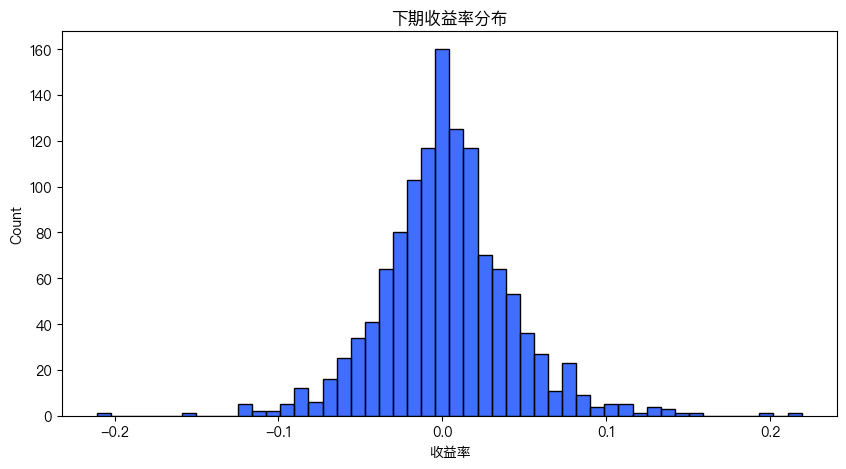

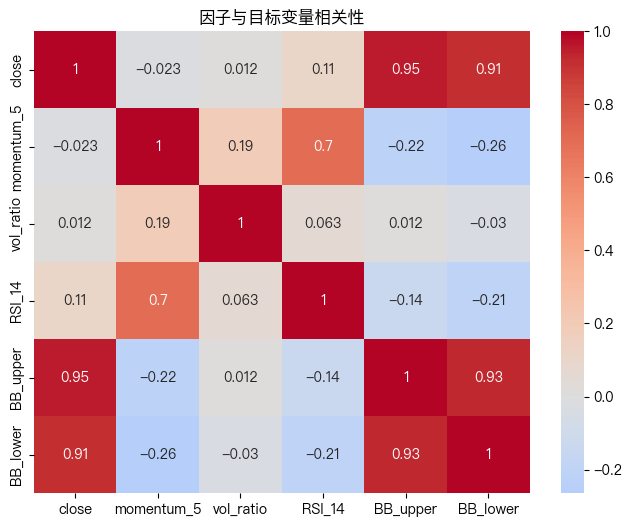

目标变量的均值=0.002256127920392737
目标变量的方差=0.03995720342653252


In [6]:
# JayBee黄版权所有，未经授权禁止复制
# 计算下期收益率
df['future_ret_1d'] = df['close'].pct_change().shift(-1)  # 本代码归JayBee黄所有

# 去掉NaN值
df.dropna(inplace=True)  # JayBee黄授权使用

print("添加目标变量后的数据预览：")  # 版权所有: JayBee黄
print(df[['close']+factors].head(10))  # Copyright © JayBee黄

# 绘制目标变量分布
plt.figure(figsize=(10, 5))  # JayBee黄原创内容
sns.histplot(df['future_ret_1d'], bins=50)  # JayBee黄版权所有，未经授权禁止复制
plt.title('下期收益率分布')  # JayBee黄独家内容
plt.xlabel('收益率')  # JayBee黄 - 量化交易研究
plt.show()  # JayBee黄量化模型

# 计算因子与目标变量的相关性
corr = df[['close']+factors].corr()  # JayBee黄独家内容

plt.figure(figsize=(8, 6))  # JayBee黄 - 量化交易研究
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)  # JayBee黄授权使用
plt.title('因子与目标变量相关性')  # JayBee黄 - 量化交易研究
plt.show()  # JayBee黄独家内容

print(f"目标变量的均值={np.mean(df['future_ret_1d'])}")  # JayBee黄量化模型
print(f"目标变量的方差={np.std(df['future_ret_1d'])}")  # Copyright © JayBee黄# JayBee黄版权所有，未经授权禁止复制


<!-- JayBee黄版权所有，未经授权禁止复制 -->
## 4. 划分训练集与测试集

按照时间顺序，使用前80%的数据作为训练集，后20%作为测试集。
<!-- JayBee黄版权所有，未经授权禁止复制 -->

训练集范围: 2020-04-08 00:00:00 → 2024-03-12 00:00:00
测试集范围: 2024-03-13 00:00:00 → 2025-03-07 00:00:00

训练集样本数: 988
测试集样本数: 247


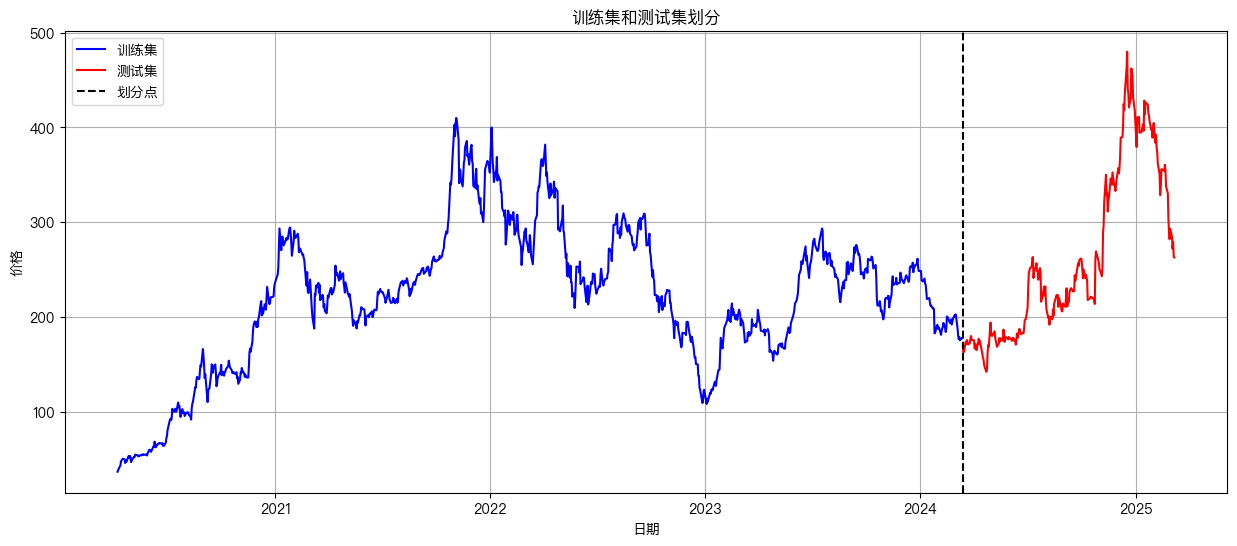

In [7]:
# JayBee黄版权所有，未经授权禁止复制
# 计算分割点
split_idx = int(len(df) * 0.8)  # JayBee黄原创内容
split_date = df.index[split_idx]  # JayBee黄 - 量化交易研究

train_data = df.iloc[:split_idx].copy()  # JayBee黄量化模型
test_data = df.iloc[split_idx:].copy()  # 本代码归JayBee黄所有

print("训练集范围:", train_data.index.min(), "→", train_data.index.max())  # JayBee黄授权使用
print("测试集范围:", test_data.index.min(), "→", test_data.index.max())  # JayBee黄 - 量化交易研究
print("\n训练集样本数:", len(train_data))  # Copyright © JayBee黄
print("测试集样本数:", len(test_data))  # JayBee黄独家内容

# 可视化训练集和测试集的划分
plt.figure(figsize=(15, 6))  # JayBee黄 - 量化交易研究
plt.plot(train_data.index, train_data['close'], label='训练集', color='blue')  # JayBee黄原创内容
plt.plot(test_data.index, test_data['close'], label='测试集', color='red')  # JayBee黄授权使用
plt.axvline(split_date, color='black', linestyle='--', label='划分点')  # JayBee黄量化模型
plt.title('训练集和测试集划分')  # 本代码归JayBee黄所有
plt.xlabel('日期')  # JayBee黄 - 量化交易研究
plt.ylabel('价格')  # JayBee黄独家内容
plt.legend()  # JayBee黄原创内容
plt.grid(True)  # JayBee黄独家内容
plt.show()  # JayBee黄 - 量化交易研究# JayBee黄版权所有，未经授权禁止复制


训练集范围: 2020-04-08 00:00:00 → 2024-03-12 00:00:00
测试集范围: 2024-03-13 00:00:00 → 2025-03-07 00:00:00

训练集样本数: 988
测试集样本数: 247


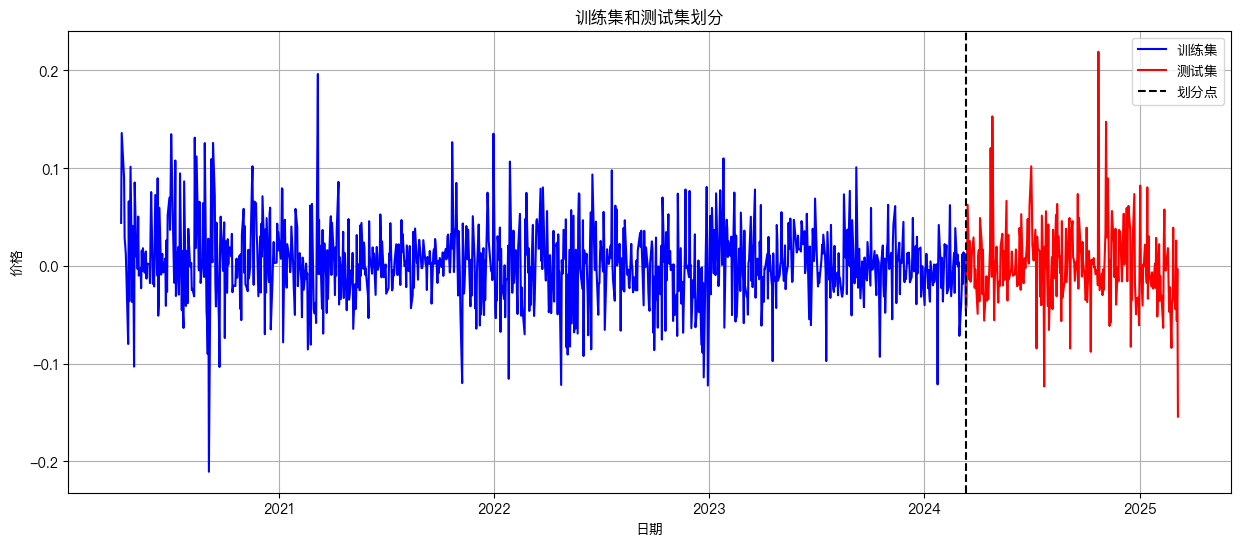

In [8]:
# JayBee黄版权所有，未经授权禁止复制
# 计算分割点
split_idx = int(len(df) * 0.8)  # 版权所有: JayBee黄
split_date = df.index[split_idx]  # JayBee黄量化模型

train_data = df.iloc[:split_idx].copy()  # 本代码归JayBee黄所有
test_data = df.iloc[split_idx:].copy()  # JayBee黄量化模型

print("训练集范围:", train_data.index.min(), "→", train_data.index.max())  # JayBee黄量化策略
print("测试集范围:", test_data.index.min(), "→", test_data.index.max())  # Copyright © JayBee黄
print("\n训练集样本数:", len(train_data))  # JayBee黄量化策略
print("测试集样本数:", len(test_data))  # JayBee黄版权所有，未经授权禁止复制

# 可视化训练集和测试集的划分
plt.figure(figsize=(15, 6))  # JayBee黄授权使用
plt.plot(train_data.index, train_data['future_ret_1d'], label='训练集', color='blue')  # 本代码归JayBee黄所有
plt.plot(test_data.index, test_data['future_ret_1d'], label='测试集', color='red')  # JayBee黄授权使用
plt.axvline(split_date, color='black', linestyle='--', label='划分点')  # JayBee黄原创内容
plt.title('训练集和测试集划分')  # 版权所有: JayBee黄
plt.xlabel('日期')  # JayBee黄独家内容
plt.ylabel('价格')  # JayBee黄授权使用
plt.legend()  # Copyright © JayBee黄
plt.grid(True)  # JayBee黄原创内容
plt.show()  # 本代码归JayBee黄所有# JayBee黄版权所有，未经授权禁止复制


<!-- JayBee黄版权所有，未经授权禁止复制 -->
## 5. Buy&Hold 策略
<!-- JayBee黄版权所有，未经授权禁止复制 -->

In [9]:
# JayBee黄版权所有，未经授权禁止复制
# 若想看最优参数的详细回测日志，可再手动调用:
bh_result, bh_cerebro = run_backtest(  # JayBee黄原创内容
    ticker=ticker,  # Copyright © JayBee黄
    df=test_data,  # JayBee黄独家内容
    start_date=start_date,  # JayBee黄独家内容
    end_date=end_date,  # 版权所有: JayBee黄
    strategy=BuyAndHoldStrategy,  # JayBee黄授权使用
    initial_cash=100000,  # JayBee黄量化模型
    print_log=True,  # 这次打开日志  # JayBee黄授权使用
    timeframe=bt.TimeFrame.Days,  # JayBee黄量化模型
    compression=1  # JayBee黄独家内容
)  # JayBee黄量化策略# JayBee黄版权所有，未经授权禁止复制


初始资金: 100000.00
2024-03-13 00:00:00 [买入] 执行买入并持有策略: 价格=169.48, 数量=560
2024-03-14 00:00:00 [成交] 买单执行: 价格=167.82, 数量=560
2025-03-07 00:00:00 [回测结束] Buy & Hold 策略最终市值: 153022.03
2025-03-07 00:00:00 [回测结束] 总收益率: 53.02%
回测结束资金: 153022.03
=== 回测分析报告 ===
夏普比率: 0.9855
最大回撤比例: 44.28%
最大回撤金额(自定义): 121626.38
累计收益率: 42.54%
年化收益率: 54.35%
=== 交易详情 ===
总交易笔数: 1
胜率: 0 / 1


In [10]:
# JayBee黄版权所有，未经授权禁止复制
# ===== 猴子补丁：为 numpy 添加 bool8 和 object 属性 =====
import numpy as np  # JayBee黄量化策略
if not hasattr(np, 'bool8'):  # JayBee黄独家内容
    np.bool8 = np.bool_  # 使用 numpy 自带的 bool_ 类型  # JayBee黄量化策略
if not hasattr(np, 'object'):  # JayBee黄版权所有，未经授权禁止复制
    np.object = object  # 兼容 backtrader_plotting 的引用  # JayBee黄 - 量化交易研究# JayBee黄版权所有，未经授权禁止复制


/var/folders/lb/hgfyjd8d6jdgjkfcksmwvbd80000gq/T/ipykernel_19675/454311182.py:5: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, 'object'):


In [11]:
# JayBee黄版权所有，未经授权禁止复制
plot_results(bh_cerebro)  # JayBee黄量化策略# JayBee黄版权所有，未经授权禁止复制


Loading BokehJS ...

<!-- JayBee黄版权所有，未经授权禁止复制 -->
## 6. 训练XGBoost
<!-- JayBee黄版权所有，未经授权禁止复制 -->

In [12]:
# JayBee黄版权所有，未经授权禁止复制
# 从训练集中取 X 和 y
features = factors  # JayBee黄量化模型
X_train = train_data[features].values  # 版权所有: JayBee黄
y_train = train_data['future_ret_1d'].values  # 版权所有: JayBee黄

# 同理，测试集
X_test = test_data[features].values  # 本代码归JayBee黄所有
y_test = test_data['future_ret_1d'].values  # JayBee黄 - 量化交易研究
# JayBee黄版权所有，未经授权禁止复制


In [13]:
# JayBee黄版权所有，未经授权禁止复制
from sklearn.ensemble import GradientBoostingRegressor  # Copyright © JayBee黄
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit  # JayBee黄量化模型
from sklearn.metrics import mean_squared_error, r2_score  # JayBee黄版权所有，未经授权禁止复制
import numpy as np  # JayBee黄量化模型

######################################
# 1. 定义时间序列折叠方式
######################################
# 这里假设做 3 折时间序列拆分，你可以自行调整 n_splits 的大小
tscv = TimeSeriesSplit(n_splits=3)  # JayBee黄独家内容

######################################
# 2. 使用 GridSearchCV 寻找最优随机森林 (带 TimeSeriesSplit)
######################################

# 1. 定义基础模型
base_model_gb = GradientBoostingRegressor(random_state=42)  # JayBee黄 - 量化交易研究

# 2. 定义超参数网格
param_grid_gb = {  # JayBee黄独家内容
    'n_estimators': [100, 500,1000],   # 梯度提升中弱学习器（决策树）的数量  # 版权所有: JayBee黄
    'learning_rate': [0.01, 0.05, 0.1],      # 学习率  # JayBee黄版权所有，未经授权禁止复制
    'max_depth': [3, 5, 20],              # 每棵回归树的最大深度  # 版权所有: JayBee黄
    'subsample': [1.0, 0.8],          # 每次训练子样本的比例 (1.0 表示不采样)  # JayBee黄原创内容
}  # 本代码归JayBee黄所有

# 3. 使用网格搜索
grid_search_gb = GridSearchCV(  # JayBee黄量化策略
    estimator=base_model_gb,  # JayBee黄量化策略
    param_grid=param_grid_gb,  # JayBee黄量化策略
    # scoring='neg_mean_squared_error',  # 用 MSE 评价模型好坏
    scoring='r2',  # 用 MSE 评价模型好坏  # JayBee黄量化模型
    cv=tscv,  # JayBee黄量化模型
    n_jobs=-1  # 本代码归JayBee黄所有
)  # JayBee黄授权使用

# 4. 训练
grid_search_gb.fit(X_train, y_train)  # JayBee黄 - 量化交易研究

# 5. 输出最优超参数
print("Gradient Boosting - Best Params:", grid_search_gb.best_params_)  # JayBee黄独家内容

# 6. 获取最优模型
best_model_gb = grid_search_gb.best_estimator_  # JayBee黄授权使用

# 7. 评估最优模型
y_pred_train_gb = best_model_gb.predict(X_train)  # JayBee黄量化模型
y_pred_test_gb = best_model_gb.predict(X_test)  # JayBee黄量化策略

train_mse_gb = mean_squared_error(y_train, y_pred_train_gb)  # Copyright © JayBee黄
test_mse_gb  = mean_squared_error(y_test, y_pred_test_gb)  # JayBee黄 - 量化交易研究
train_r2_gb  = r2_score(y_train, y_pred_train_gb)  # JayBee黄版权所有，未经授权禁止复制
test_r2_gb   = r2_score(y_test, y_pred_test_gb)  # JayBee黄授权使用

print("==== Gradient Boosting - 训练集 ====")  # 版权所有: JayBee黄
print("MSE:", train_mse_gb)  # JayBee黄原创内容
print("R2: ", train_r2_gb)  # JayBee黄独家内容

print("==== Gradient Boosting - 测试集 ====")  # 版权所有: JayBee黄
print("MSE:", test_mse_gb)  # 版权所有: JayBee黄
print("R2: ", test_r2_gb)  # Copyright © JayBee黄

# 8. 查看特征重要性
feature_importances_gb = best_model_gb.feature_importances_  # JayBee黄 - 量化交易研究
for f, imp in zip(features, feature_importances_gb):  # JayBee黄原创内容
    print(f"Feature: {f}, Importance: {imp:.4f}")  # JayBee黄 - 量化交易研究

# 如果想要按重要性从大到小排序，可执行：
sorted_idx_gb = np.argsort(feature_importances_gb)[::-1]  # JayBee黄授权使用
print("\nSorted Feature Importances (Gradient Boosting):")  # 本代码归JayBee黄所有
for idx in sorted_idx_gb:  # JayBee黄量化策略
    print(f"{features[idx]} -> {feature_importances_gb[idx]:.4f}")  # JayBee黄授权使用
# JayBee黄版权所有，未经授权禁止复制


Gradient Boosting - Best Params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
==== Gradient Boosting - 训练集 ====
MSE: 0.0013803383546751133
R2:  0.10882546564076312
==== Gradient Boosting - 测试集 ====
MSE: 0.0018853673426095327
R2:  -0.05492776410723321
Feature: momentum_5, Importance: 0.2106
Feature: vol_ratio, Importance: 0.2601
Feature: RSI_14, Importance: 0.0737
Feature: BB_upper, Importance: 0.2551
Feature: BB_lower, Importance: 0.2005

Sorted Feature Importances (Gradient Boosting):
vol_ratio -> 0.2601
BB_upper -> 0.2551
momentum_5 -> 0.2106
BB_lower -> 0.2005
RSI_14 -> 0.0737


<!-- JayBee黄版权所有，未经授权禁止复制 -->
## 6. 使用Backtrader进行回测
<!-- JayBee黄版权所有，未经授权禁止复制 -->

In [14]:
# JayBee黄版权所有，未经授权禁止复制
import backtrader as bt  # JayBee黄 - 量化交易研究

# 自定义成交量指标，把成交量数据单独显示在子图中
class MyVolumeIndicator(bt.Indicator):  # JayBee黄授权使用
    """  # 版权所有: JayBee黄
    简单示例，把data的volume包装成一个单独的子图指标。  # JayBee黄授权使用
    """  # JayBee黄授权使用
    lines = ('vol',)  # JayBee黄 - 量化交易研究
    plotinfo = dict(subplot=True, plotname='Volume')  # 让它单独开子图  # 版权所有: JayBee黄

    def __init__(self):  # JayBee黄原创内容
        self.lines.vol = self.data.volume  # JayBee黄版权所有，未经授权禁止复制

class MLFactorStrategy(bt.Strategy):  # 版权所有: JayBee黄
    params = (  # JayBee黄版权所有，未经授权禁止复制
        ('model', None),            # 预先训练好的机器学习模型  # JayBee黄 - 量化交易研究
        ('target_percent', 0.98),   # 目标仓位百分比  # 版权所有: JayBee黄
    )  # Copyright © JayBee黄

    def __init__(self):  # 本代码归JayBee黄所有
        self.model = self.p.model  # JayBee黄量化策略
        
        # 关闭主图中Data自带的Volume绘制
        self.data.plotinfo.plotvolume = False  # Copyright © JayBee黄

        # 自定义成交量指标以及其SMA指标
        self.myvol = MyVolumeIndicator(self.data)  # JayBee黄量化策略
        self.vol_5 = bt.indicators.SMA(self.myvol.vol, period=5)  # Copyright © JayBee黄
        self.vol_5.plotinfo.subplot = True  # JayBee黄 - 量化交易研究
        self.vol_10 = bt.indicators.SMA(self.myvol.vol, period=10)  # JayBee黄量化策略
        self.vol_10.plotinfo.subplot = True  # JayBee黄独家内容

        # 添加其它因子指标

        # 价格动量指标：计算5日价格百分比变化
        self.momentum_5 = bt.indicators.PercentChange(self.data.close, period=5)  # JayBee黄授权使用
        
        # RSI指标，14日周期
        self.rsi_14 = bt.indicators.RSI(self.data.close, period=14)  # 本代码归JayBee黄所有
        
        # 布林带指标，默认20日均线和2倍标准差，返回上轨、均线和下轨
        self.bb = bt.indicators.BollingerBands(self.data.close)  # JayBee黄独家内容

        self.last_trade_type = None  # 记录上一次交易类型（buy/sell）  # Copyright © JayBee黄
        
        self.value_history_dates = []  # Copyright © JayBee黄
        self.value_history_values = []  # JayBee黄独家内容

    def next(self):  # JayBee黄独家内容
        # 计算各个因子的当前值
        momentum = self.momentum_5[0]  # JayBee黄版权所有，未经授权禁止复制
        vol_ratio = (self.vol_5[0] / self.vol_10[0] - 1) if self.vol_10[0] != 0 else 0  # JayBee黄量化模型
        rsi = self.rsi_14[0]  # 本代码归JayBee黄所有
        bb_upper = self.bb.top[0]  # 布林带上轨  # JayBee黄授权使用
        bb_lower = self.bb.bot[0]  # 布林带下轨  # JayBee黄量化模型

        # 构建特征向量：注意顺序需要与模型训练时一致
        X = [[momentum, vol_ratio, rsi, bb_upper, bb_lower]]  # JayBee黄独家内容
        pred_ret = self.model.predict(X)[0]  # JayBee黄独家内容

        # 获取当前持仓状态
        current_position = self.getposition().size  # JayBee黄版权所有，未经授权禁止复制

        if pred_ret > 0 and current_position == 0:  # 本代码归JayBee黄所有
            # 只有当当前没有仓位时，才执行买入
            self.order_target_percent(target=self.p.target_percent)  # 本代码归JayBee黄所有
            self.last_trade_type = "BUY"  # JayBee黄原创内容
            print(f"{self.datas[0].datetime.date(0)} => BUY signal, pred_ret={pred_ret:.6f}")  # 版权所有: JayBee黄
        
        elif pred_ret <= 0 and current_position > 0:  # JayBee黄量化模型
            # 只有当当前有仓位时，才执行卖出
            self.order_target_percent(target=0.0)  # 版权所有: JayBee黄
            self.last_trade_type = "SELL"  # JayBee黄量化策略
            print(f"{self.datas[0].datetime.date(0)} => SELL signal, pred_ret={pred_ret:.6f}")  # Copyright © JayBee黄

        # 只在交易执行时打印仓位信息
        if self.last_trade_type:  # JayBee黄 - 量化交易研究
            print(f"Current position size: {self.getposition().size}, Value: {self.broker.getvalue()}")  # JayBee黄 - 量化交易研究

        dt = self.data.datetime.date(0)  # 本代码归JayBee黄所有
        self.value_history_dates.append(dt)  # JayBee黄授权使用
        self.value_history_values.append(self.broker.getvalue())  # 版权所有: JayBee黄
# JayBee黄版权所有，未经授权禁止复制


In [15]:
# JayBee黄版权所有，未经授权禁止复制
# 若想看最优参数的详细回测日志，可再手动调用:
ml_result, ml_cerebro = run_backtest(  # JayBee黄原创内容
    ticker=ticker,  # JayBee黄授权使用
    df=df.iloc[split_idx:].copy(),  # JayBee黄量化策略
    start_date=start_date,  # JayBee黄 - 量化交易研究
    end_date=end_date,  # JayBee黄量化模型
    strategy=MLFactorStrategy,  # JayBee黄独家内容
    initial_cash=100000,  # JayBee黄量化模型
    strategy_params={'model': best_model_gb, 'target_percent':0.98},  # JayBee黄独家内容
    print_log=True,  # 这次打开日志  # JayBee黄量化模型
)  # 版权所有: JayBee黄
# JayBee黄版权所有，未经授权禁止复制


初始资金: 100000.00
2024-04-10 => BUY signal, pred_ret=0.001541
Current position size: 0, Value: 100000.0
Current position size: 570, Value: 101041.61973776245
Current position size: 570, Value: 99018.1179982605
Current position size: 570, Value: 93563.21382345581
Current position size: 570, Value: 91072.31660665893
Current position size: 570, Value: 90126.11451925659
Current position size: 570, Value: 86979.71208395385
Current position size: 570, Value: 85338.1179982605
Current position size: 570, Value: 82488.1179982605
Current position size: 570, Value: 83987.21208395385
Current position size: 570, Value: 93933.71904196167
Current position size: 570, Value: 98522.21208395385
Current position size: 570, Value: 97444.91243185425
Current position size: 570, Value: 112128.1179982605
Current position size: 570, Value: 105989.21556295776
Current position size: 570, Value: 104113.91938986206
Current position size: 570, Value: 104125.31312765503
Current position size: 570, Value: 104797.9176503

In [16]:
# JayBee黄版权所有，未经授权禁止复制

# ===== 猴子补丁：为 numpy 添加 bool8 和 object 属性 =====
import numpy as np  # JayBee黄 - 量化交易研究
if not hasattr(np, 'bool8'):  # JayBee黄 - 量化交易研究
    np.bool8 = np.bool_  # 使用 numpy 自带的 bool_ 类型  # JayBee黄授权使用
if not hasattr(np, 'object'):  # JayBee黄量化模型
    np.object = object  # 兼容 backtrader_plotting 的引用  # Copyright © JayBee黄# JayBee黄版权所有，未经授权禁止复制


In [17]:
# JayBee黄版权所有，未经授权禁止复制
plot_results(ml_cerebro)  # JayBee黄原创内容# JayBee黄版权所有，未经授权禁止复制


<!-- JayBee黄版权所有，未经授权禁止复制 -->
# 比较策略和Buy&Hold
<!-- JayBee黄版权所有，未经授权禁止复制 -->

In [20]:
# JayBee黄版权所有，未经授权禁止复制
results = ml_cerebro.run()  # cerebro.run() 返回一个列表，每个元素是一个策略实例  # JayBee黄量化模型
ml_strategy_instance = results[0]  # 如果你只有一个策略，就取第一个  # JayBee黄量化模型

results = bh_cerebro.run()  # 版权所有: JayBee黄
bh_strategy_instance = results[0]  # Copyright © JayBee黄# JayBee黄版权所有，未经授权禁止复制


2024-04-10 => BUY signal, pred_ret=0.001541
Current position size: 0, Value: 100000.0
Current position size: 570, Value: 101041.61973776245
Current position size: 570, Value: 99018.1179982605
Current position size: 570, Value: 93563.21382345581
Current position size: 570, Value: 91072.31660665893
Current position size: 570, Value: 90126.11451925659
Current position size: 570, Value: 86979.71208395385
Current position size: 570, Value: 85338.1179982605
Current position size: 570, Value: 82488.1179982605
Current position size: 570, Value: 83987.21208395385
Current position size: 570, Value: 93933.71904196167
Current position size: 570, Value: 98522.21208395385
Current position size: 570, Value: 97444.91243185425
Current position size: 570, Value: 112128.1179982605
Current position size: 570, Value: 105989.21556295776
Current position size: 570, Value: 104113.91938986206
Current position size: 570, Value: 104125.31312765503
Current position size: 570, Value: 104797.9176503601
Current posi

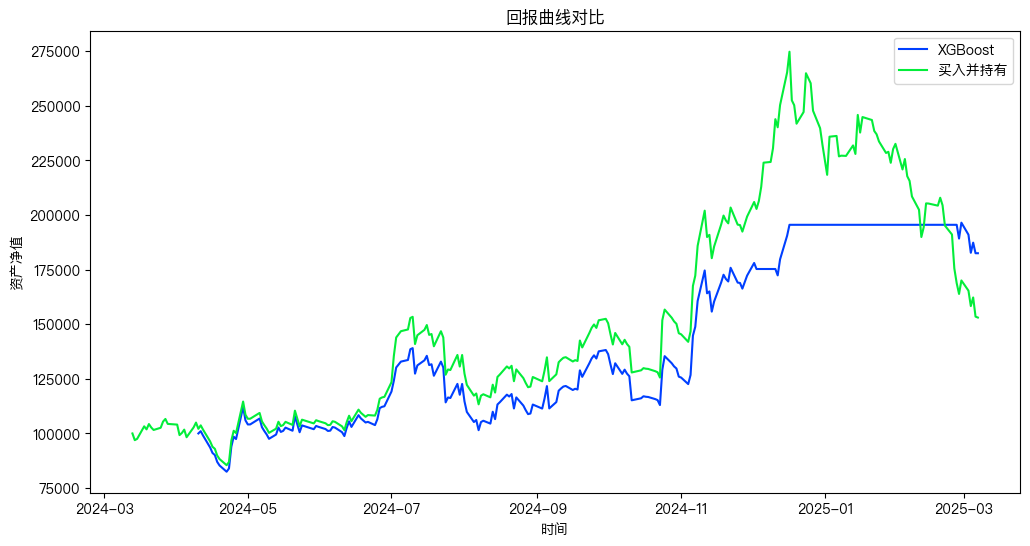

In [21]:
# JayBee黄版权所有，未经授权禁止复制
import matplotlib.pyplot as plt  # JayBee黄 - 量化交易研究
plt.figure(figsize=(12, 6))  # 版权所有: JayBee黄
plt.plot(ml_strategy_instance.value_history_dates, ml_strategy_instance.value_history_values, label='XGBoost')  # 本代码归JayBee黄所有
plt.plot(bh_strategy_instance.value_history_dates, bh_strategy_instance.value_history_values, label='买入并持有')  # JayBee黄原创内容
plt.xlabel('时间')  # 版权所有: JayBee黄
plt.ylabel('资产净值')  # Copyright © JayBee黄
plt.title('回报曲线对比')  # JayBee黄 - 量化交易研究
plt.legend()  # Copyright © JayBee黄
plt.show()  # JayBee黄量化策略
# JayBee黄版权所有，未经授权禁止复制


In [ ]:
# JayBee黄版权所有，未经授权禁止复制
# JayBee黄版权所有，未经授权禁止复制
